# Итоговый проект (урок № 9), Кривоногов Н.В.

## Step 1: TRAIN

### Обучение пайплайна

1. Загружаю данные:

Один мой друг Дмитрий Шелгунов поставил себе такую задачу: приготовить плов 100 раз - и только сотый по счету плов он признает удавшимся, таким образом научится готовить его. 

Именно в честь Шела я выбрал набор данных для бинарной классификации риса - основного ингридиента этого замечательного блюда: https://archive.ics.uci.edu/ml/datasets/Rice+%28Cammeo+and+Osmancik%29

2. Собираю пайплайн
3. Обучаю логистическую регрессию и сохраняю на диск предобученный пайплайн

In [1]:
import pandas as pd
import dill
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score

In [2]:
df = pd.read_csv("./Rice_Osmancik_Cammeo_Dataset.csv")

df.head(3)

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo


In [3]:
# для традиционного вида сделаю названия признаков строчными буквами:

df.columns = map(str.lower, df.columns)

df.head(3)

,area,perimeter,majoraxis,minoraxis,eccentricity,convex_area,extent,class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo


In [4]:
df['class'].value_counts()

Osmancik    2180
Cammeo      1630
Name: class, dtype: int64

In [5]:
# провожу бинарное кодирование целевой переменной: 

df['class'] = df['class'].map({'Cammeo': 1, 'Osmancik': 0})

# проверка:

df.head(3)

,area,perimeter,majoraxis,minoraxis,eccentricity,convex_area,extent,class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,1
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,1
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,1


In [6]:
# разделяю данные на train/test и сохраняю тестовую выборку на диск:

X_train, X_test, y_train, y_test = train_test_split(df, df['class'],
                                                    test_size=0.33, random_state=42)
# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    

class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

После первичного обучения модели посмотрел на наиболее важные признаки: 

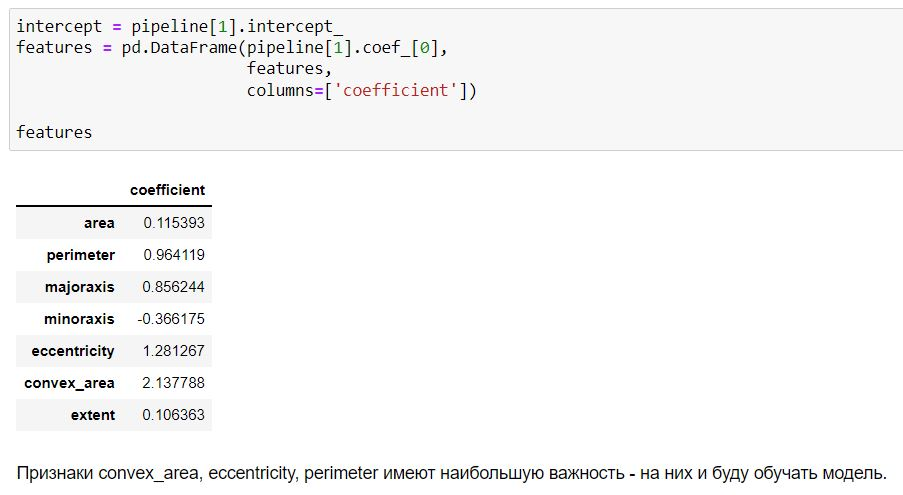

In [8]:
# отбираю признаки, на которых буду обучать модель: 

features = ['convex_area', 'eccentricity', 'perimeter']
target = 'class'

Собираю кусок, ответственный за feature engineering

In [9]:
# собираю наш простой pipeline, но мне понадобится написать класс для выбора нужного поля:

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [10]:
final_transformers = list()

for cont_col in features:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

Добавляю простейший классификатор

In [11]:
%%time

pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression()),
])

pipeline.fit(X_train, y_train)

Wall time: 47 ms


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('convex_area',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='convex_area')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('eccentricity',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='eccentricity')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('perimeter',
                                                 Pipeline(steps=[('selector',
             

In [12]:
# смотрю, как выглядит pipeline

pipeline.steps

[('features',
  FeatureUnion(transformer_list=[('convex_area',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='convex_area')),
                                                  ('scaler', StandardScaler())])),
                                 ('eccentricity',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='eccentricity')),
                                                  ('scaler', StandardScaler())])),
                                 ('perimeter',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='perimeter')),
                                                  ('scaler',
                                                   StandardScaler())]))])),
 ('classifier', LogisticRegression())]

In [13]:
# features = pd.DataFrame(pipeline[1].coef_[0], 
#                         features, 
#                         columns=['coefficient'])

# features

In [14]:
# Признаки convex_area, eccentricity, perimeter имеют наибольшую важность - на них и буду обучать модель. 

In [15]:
# сохраняю модель (пайплайн):

with open("logreg_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)